<a href="https://colab.research.google.com/github/andrew-alberts/deep-learning-cv-tutorial/blob/main/dl_and_cv_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning and Computer Vision Tutorial

This notebook walks through an introductory computer vision task which uses deep learning to determine the make of car from it's picture. The dataset used is Stanford196 and the TensorFlow and Keras frameworks are used throughout.

### Agenda

1. General notebook setup
2. Loading the data
3. Data preprocessing
4. Fully-connected neural network
5. Convolutional neural network (CNN)
6. ResNet



### 1 - General notebook setup

Colab fortunately is already well equipped for us, but we need to use a GPU. To do so click Runtime > Change runtime type and select GPU as the Hardware accelerator (GPU).

Now, we can verify we have a GPU and see what version of TensorFlow is available.

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
print("GPU:", device_name)
print("TF version:", tf.__version__)

GPU: /device:GPU:0
TF version: 2.4.1


Set seeds to get results are reproducible as possible, however because we use a GPU they won't be fully reproducible.

In [ ]:
import os
import random
import numpy as np

seed_value = 10
os.environ["PYTHONHASHSEED"]=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

We need to mount a Google drive if the dataset is already downloaded and residing in the drive (set LOAD_FROM_DRIVE to True). If not, keep it as False and the dataset will be downloaded on the fly.

In [ ]:
LOAD_FROM_DRIVE = False

data_dir = None
download = True

if LOAD_FROM_DRIVE:
  from google.colab import drive
  drive.mount("/content/drive")
  data_dir = "drive/MyDrive/tensorflow_datasets"
  download = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2 - Load the dataset

Loading the Cars196 dataset is really easy using the tensorflow_datasets module. The tfds.load function takes care of either downloading the data or simply loading the data from a mounted drive.

In [ ]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load("Cars196", split=["train", "test"], data_dir=data_dir, download=download,
                                         with_info=True, shuffle_files=True, as_supervised=True)
print("ds_train type", type(ds_train))
print("ds_info type", type(ds_info))

ds_train type <class 'tensorflow.python.data.ops.dataset_ops._OptionsDataset'>
ds_info type <class 'tensorflow_datasets.core.dataset_info.DatasetInfo'>


Quick view of a sample of images and the given labels.

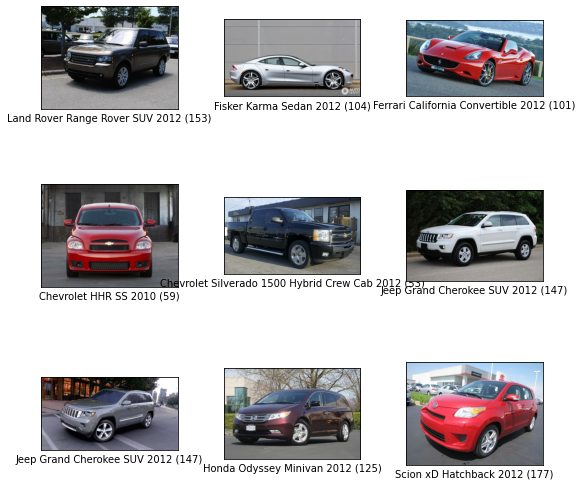

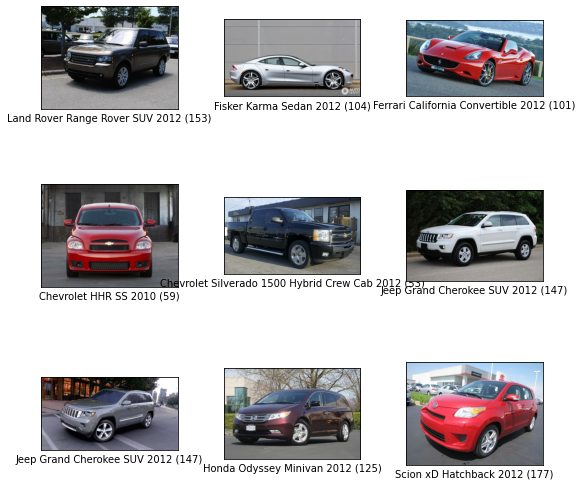

In [ ]:
tfds.visualization.show_examples(ds_train, ds_info)

Check out a sample of the image labels. There are 196 distinct classes in the form *make model year*.

In [ ]:
print("# classes", len(ds_info._features["label"]._str2int), "\n")
{s:i for s, i in ds_info._features["label"]._str2int.items() if (i % 18) == 0}

# classes 196 



{'AM General Hummer SUV 2000': 0,
 'Audi TT Hatchback 2011': 18,
 'BMW X3 SUV 2012': 36,
 'Chevrolet Corvette Convertible 2012': 54,
 'Chevrolet Malibu Sedan 2007': 72,
 'Dodge Dakota Club Cab 2007': 90,
 'Ford Expedition EL SUV 2009': 108,
 'Honda Odyssey Minivan 2007': 126,
 'Jeep Patriot SUV 2012': 144,
 'Mercedes-Benz SL-Class Coupe 2009': 162,
 'Suzuki Aerio Sedan 2007': 180}

How is the data actually represented? Their data types are tf.Tensor where the image has dimension *H*x*W*x*3* and the label is a scalar. By looking at two different samples we see the images have different heights and widths.

In [ ]:
def show_tensors(ds):
  for img, lbl in ds.take(2):
    print("Image")
    print(type(img), img.shape)
    print("Label", lbl)
    print(type(lbl), lbl.shape)
    print(50*"-")
  return img, lbl

sample_image, sample_label = show_tensors(ds_train)

Image
<class 'tensorflow.python.framework.ops.EagerTensor'> (300, 400, 3)
Label tf.Tensor(152, shape=(), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'> ()
--------------------------------------------------
Image
<class 'tensorflow.python.framework.ops.EagerTensor'> (341, 480, 3)
Label tf.Tensor(159, shape=(), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'> ()
--------------------------------------------------


Visualize one image.

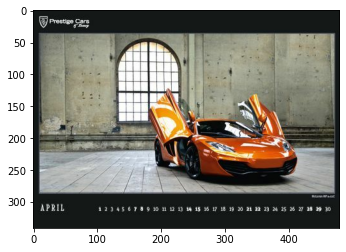

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(sample_image.numpy(), cmap="gray")

### 3 - Data preprocessing

Since the labels have more information than just the make, let's strip out the model and year for this tutorial. The functions below will be used to map the 196 classes down to 48 classes.

In [ ]:
def label_str_to_make(label_str):
  lbl = label_str.upper()
  if "HUMMER" in lbl:
    return "AM"
  elif "ASTON MARTIN" in lbl:
    return "ASTON MARTIN"
  elif "LAND ROVER" in lbl:
    return "LAND ROVER"
  else:
    return lbl.split(" ")[0]

makes = list(set([label_str_to_make(x) for x in ds_info._features["label"]._int2str]))

def get_new_label(label_int):
  label_str = ds_info._features["label"]._int2str[label_int]
  make = label_str_to_make(label_str)
  return makes.index(make)

print("# classes", len(makes), ",  examples", makes[0:5])

# classes 48 ,  examples ['MERCEDES-BENZ', 'TESLA', 'TOYOTA', 'CHRYSLER', 'FORD']


Our neural nets will require the input images to have a fixed size but we saw that is not the case. Let's write a function to reshape images to be *150*x*150*x*3*. It is also common practice to normalize pixel values to be between 0 to 1 (instead of 0 to 255).


In [ ]:
def normalize_img(img, size=150):
  img = tf.image.resize(img, (size,size), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False)
  img = img / 255.
  return img

What does a resized picture look like?

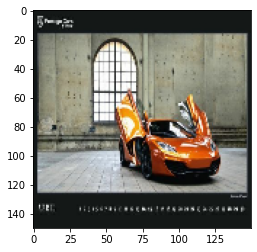

In [ ]:
plt.imshow(normalize_img(sample_image).numpy(), cmap="gray")

With the functions to relabel the samples and reshape them, we can now apply these preprocessing steps to the training data.

In [ ]:
def relabel_and_reshape(img, label):
  lbl = tf.numpy_function(
      func=get_new_label, inp=[label], Tout=tf.int64
  )
  return normalize_img(img), lbl

ds_train = ds_train.map(relabel_and_reshape, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Check the reshaping worked.

In [ ]:
_, _ = show_tensors(ds_train)

Image
<class 'tensorflow.python.framework.ops.EagerTensor'> (150, 150, 3)
Label tf.Tensor(14, shape=(), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'> ()
--------------------------------------------------
Image
<class 'tensorflow.python.framework.ops.EagerTensor'> (150, 150, 3)
Label tf.Tensor(25, shape=(), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'> ()
--------------------------------------------------


Another common practice is to zero-centre the images so that all pixels have an average of 0. To do this we need to first calculate the mean of the pixel values:

In [ ]:
total_tensor = tf.zeros([150, 150, 3])
n = 0

for img, _ in iter(ds_train):
  n += 1
  total_tensor += img

avg_tensor = total_tensor / n
print("Shape", avg_tensor.shape)

Shape (150, 150, 3)


Now we need to subtract the mean from all images in our training dataset.

In [ ]:
def centre_images(img, label):
  return (img-avg_tensor), label

ds_train = ds_train.map(centre_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Finally, it is important to apply the same transformations to the test dataset.

In [ ]:
ds_test = ds_test.map(relabel_and_reshape, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(centre_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

### 4 - Fully connected neural-network 

We flatten the image into a long tensor and proceed basic dense layers. This is not ideal for image data but is presented for pedagogic purposes.

Before building the model, we should ask: **What accuracy do we need to beat?** One way to make predictions without even needing a neural net is to always predict the most frequent label. Doing so would give us around 11.12% accuracy.


In [ ]:
from collections import Counter

labels = [lbl.numpy() for _, lbl in iter(ds_test)]
n_samples = len(labels)
freq_counts = Counter(labels)
n_most_frequent = max([count for lbl, count in freq_counts.items()])
most_frequent_lbl = [lbl for lbl, count in freq_counts.items() if count == n_most_frequent][0]
text_lbl = makes[most_frequent_lbl]

print(f"Most frequent label is {most_frequent_lbl} ({text_lbl}) which occurs {n_most_frequent} times out of {n_samples} samples.")

dominant_label_accuracy = round(100 * n_most_frequent / n_samples, 2)

print(f"Predicting {text_lbl} all the time would have {dominant_label_accuracy}% accuracy.")

Most frequent label is 11 (CHEVROLET) which occurs 894 times out of 8041 samples.
Predicting CHEVROLET all the time would have 11.12% accuracy.


**Batch the data.** We batch images together the the neural net receives multiple images in one forward pass.

In [ ]:
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

**Fitting the neural network**. One  layer for input, one hidden layer and a layer to represent the output.

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(150, 150, 3)),  # images are is 150x150x3
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(48)                            # there are 48 output classes
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
)

Epoch 1/10
64/64 [==============================] - 51s 447ms/step - loss: 6.0843 - sparse_categorical_accuracy: 0.0496 - val_loss: 4.7601 - val_sparse_categorical_accuracy: 0.0657
Epoch 2/10
64/64 [==============================] - 2s 27ms/step - loss: 3.7665 - sparse_categorical_accuracy: 0.1523 - val_loss: 5.0163 - val_sparse_categorical_accuracy: 0.0719
Epoch 3/10
64/64 [==============================] - 2s 25ms/step - loss: 3.2458 - sparse_categorical_accuracy: 0.2334 - val_loss: 4.5361 - val_sparse_categorical_accuracy: 0.0732
Epoch 4/10
64/64 [==============================] - 2s 26ms/step - loss: 2.4446 - sparse_categorical_accuracy: 0.3506 - val_loss: 4.8364 - val_sparse_categorical_accuracy: 0.0772
Epoch 5/10
64/64 [==============================] - 2s 25ms/step - loss: 2.0913 - sparse_categorical_accuracy: 0.4451 - val_loss: 4.7721 - val_sparse_categorical_accuracy: 0.0810
Epoch 6/10
64/64 [==============================] - 2s 26ms/step - loss: 1.7644 - sparse_categorical_ac

**Visualizing loss and accuracy curves.** This is important to understand the training and accuracy of the model.

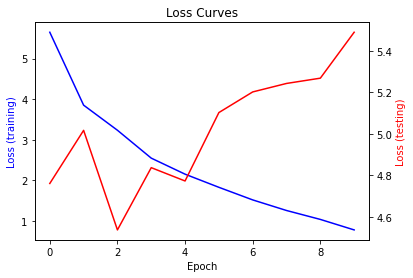

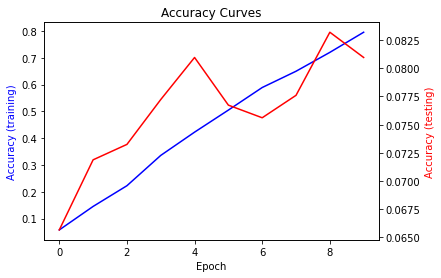

In [ ]:
def plot_loss_curves(history):
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.plot(history.history["loss"], "b")
  ax2.plot(history.history["val_loss"], "r")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss (training)", color="b")
  ax2.set_ylabel("Loss (testing)", color="r")
  plt.title("Loss Curves")
  plt.show()

  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.plot(history.history["sparse_categorical_accuracy"], "b")
  ax2.plot(history.history["val_sparse_categorical_accuracy"], "r")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Accuracy (training)", color="b")
  ax2.set_ylabel("Accuracy (testing)", color="r")
  plt.title("Accuracy Curves")
  plt.show()

plot_loss_curves(history)

**Check model predictions.** See what our model is saying for a few instances.

Prediction: MERCEDES-BENZ     |   Truth: FERRARI


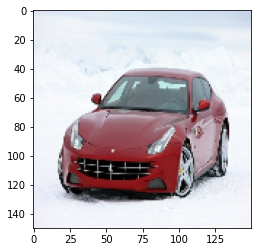

Prediction: DODGE     |   Truth: AUDI


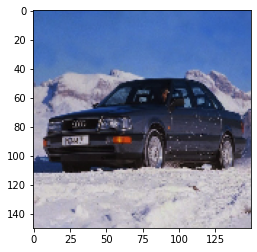

Prediction: CHEVROLET     |   Truth: GEO


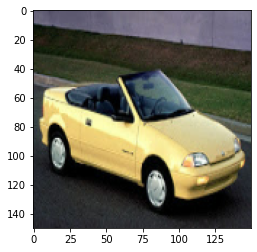

In [ ]:
def show_predictions(mdl, ds, n=3):
  for imgs, lbls in ds:
    for i in range(0, n):
      x = imgs[i] 
      prediction = mdl.predict(tf.reshape(x, [1, 150, 150, 3]))
      prediction = int(np.argmax(prediction, axis=-1))
      truth = int(lbls[i])
      print("Prediction:", makes[prediction], "    |   Truth:", makes[truth] )
      plt.imshow((x+avg_tensor).numpy(), cmap="gray")
      plt.show()

show_predictions(model, ds_test.take(1))

Printing the model summary to summarize the layers of the model.

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 67500)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                3375050   
_________________________________________________________________
dense_1 (Dense)              (None, 48)                2448      
Total params: 3,377,498
Trainable params: 3,377,498
Non-trainable params: 0
_________________________________________________________________
None


Visual display of the layers of the model.

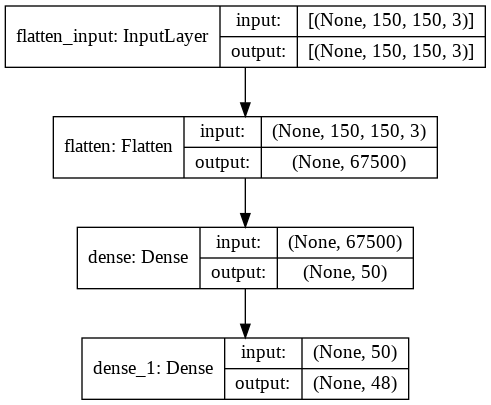

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

### 2 - Convolutional neural network (CNN)

Results from the previous model were unsurpisingly poor. The model was very simplistic and wasn't optimal for images. CNNs on the other hand are well suited for data structured like images.

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),                               
  tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(48)  
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test,
)

Epoch 1/20
64/64 [==============================] - 36s 91ms/step - loss: 5.7182 - sparse_categorical_accuracy: 0.0757 - val_loss: 3.3081 - val_sparse_categorical_accuracy: 0.1278
Epoch 2/20
64/64 [==============================] - 5s 78ms/step - loss: 2.4844 - sparse_categorical_accuracy: 0.3492 - val_loss: 3.3342 - val_sparse_categorical_accuracy: 0.1323
Epoch 3/20
64/64 [==============================] - 5s 79ms/step - loss: 1.4561 - sparse_categorical_accuracy: 0.6445 - val_loss: 3.7377 - val_sparse_categorical_accuracy: 0.1061
Epoch 4/20
64/64 [==============================] - 5s 78ms/step - loss: 0.7040 - sparse_categorical_accuracy: 0.8543 - val_loss: 4.1879 - val_sparse_categorical_accuracy: 0.1242
Epoch 5/20
64/64 [==============================] - 5s 79ms/step - loss: 0.2760 - sparse_categorical_accuracy: 0.9668 - val_loss: 4.5618 - val_sparse_categorical_accuracy: 0.1272
Epoch 6/20
64/64 [==============================] - 5s 80ms/step - loss: 0.1075 - sparse_categorical_acc

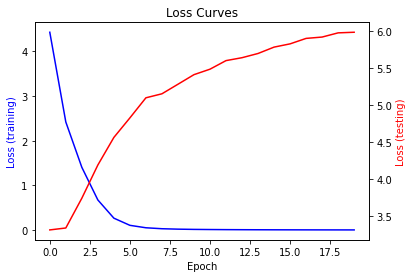

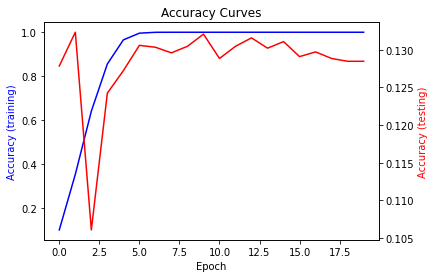

In [ ]:
plot_loss_curves(history)

**Trying out a deeper architecture.**

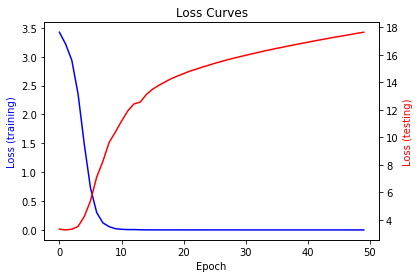

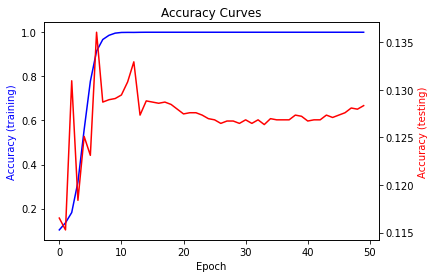

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),                               
  tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),                               
  tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),                               
  tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(48)  
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=50,
    validation_data=ds_test,
    verbose=0
)

plot_loss_curves(history)

### 6 - ResNet

So, it seems pretty hard to think up an architecture that outperforms the baseline. Though it seems all hope is lost - it is not! The last trick of the day is to use a well known and well performing existing architecture (ResNet50) as a starting-off point.

(*Source*: https://www.pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input

resnet = ResNet50(weights="imagenet", input_tensor=Input(shape=(150, 150, 3)), include_top=False)
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Need to align the pool_size with the dimension of the last layer in the summary above.

In [ ]:
model = resnet.output
model = tf.keras.layers.AveragePooling2D(pool_size=(5, 5))(model)
model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.Dense(256, activation="relu")(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(48)(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs=model)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    batch_size=128,
    epochs=18, 
    validation_data=ds_test,
    shuffle=True,
)

Epoch 1/18
64/64 [==============================] - 73s 995ms/step - loss: 3.6696 - sparse_categorical_accuracy: 0.0985 - val_loss: 3.6689 - val_sparse_categorical_accuracy: 0.0652
Epoch 2/18
64/64 [==============================] - 58s 911ms/step - loss: 2.9053 - sparse_categorical_accuracy: 0.2513 - val_loss: 3.6042 - val_sparse_categorical_accuracy: 0.0652
Epoch 3/18
64/64 [==============================] - 58s 913ms/step - loss: 2.4119 - sparse_categorical_accuracy: 0.3655 - val_loss: 3.6113 - val_sparse_categorical_accuracy: 0.1060
Epoch 4/18
64/64 [==============================] - 58s 914ms/step - loss: 2.0229 - sparse_categorical_accuracy: 0.4601 - val_loss: 3.6338 - val_sparse_categorical_accuracy: 0.0652
Epoch 5/18
64/64 [==============================] - 58s 915ms/step - loss: 1.6327 - sparse_categorical_accuracy: 0.5538 - val_loss: 3.9054 - val_sparse_categorical_accuracy: 0.1112
Epoch 6/18
64/64 [==============================] - 58s 915ms/step - loss: 1.3052 - sparse_cate

Learning curves.

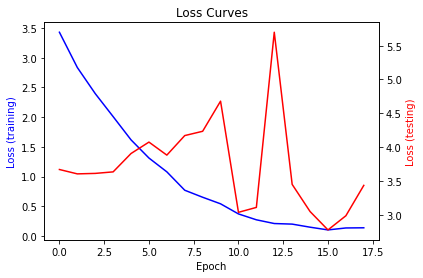

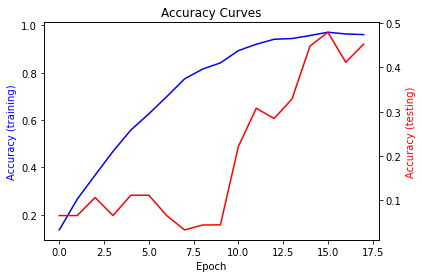

In [ ]:
plot_loss_curves(history)

**Check model predictions.**

Prediction: FERRARI     |   Truth: FERRARI


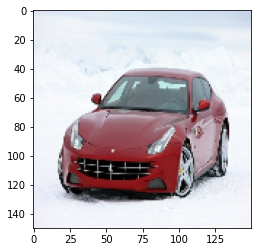

Prediction: AUDI     |   Truth: AUDI


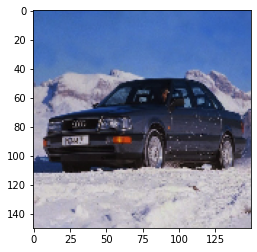

Prediction: GEO     |   Truth: GEO


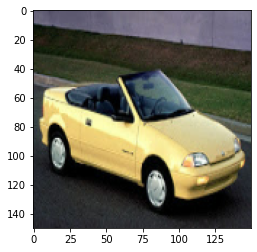

Prediction: BMW     |   Truth: BMW


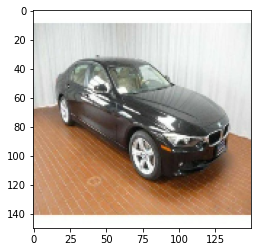

Prediction: ROLLS-ROYCE     |   Truth: MERCEDES-BENZ


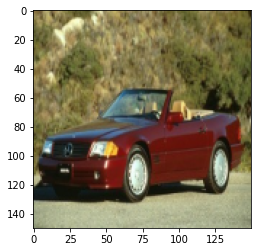

In [ ]:
show_predictions(model, ds_test.take(1), 5)

**Hint**: It is possible to continue training the same model. Notice the learning rate is decreased to not move away too far from the good results achieved above.

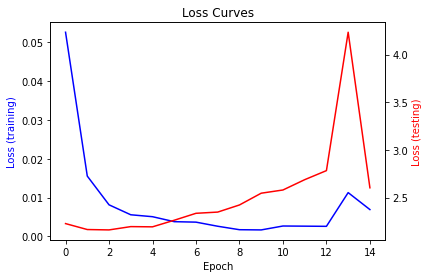

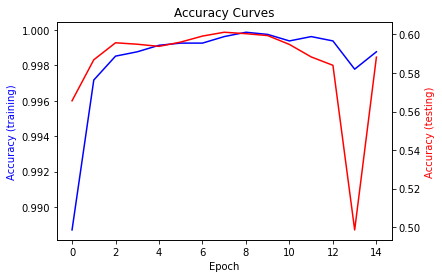

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    batch_size=128,
    epochs=15, 
    validation_data=ds_test,
    shuffle=True,
    verbose=0
)

plot_loss_curves(history)